https://github.com/PAIR-code/saliency/blob/master/Examples_pytorch.ipynb

In [1]:
# Boilerplate imports.
import numpy as np
import PIL.Image
from matplotlib import pylab as P
import torch
from torchvision import models, transforms

# From our repository.
import saliency.core as saliency

%matplotlib inline

/Users/junginseo/opt/anaconda3/envs/dl_env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/junginseo/opt/anaconda3/envs/dl_env/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Boilerplate methods.
def ShowImage(im, title='', ax=None):
    if ax is None:
        P.figure()
    P.axis('off')
    P.imshow(im)
    P.title(title)

def ShowGrayscaleImage(im, title='', ax=None):
    if ax is None:
        P.figure()
    P.axis('off')
    P.imshow(im, cmap=P.cm.gray, vmin=0, vmax=1)
    P.title(title)

def ShowHeatMap(im, title, ax=None):
    if ax is None:
        P.figure()
    P.axis('off')
    P.imshow(im, cmap='inferno')
    P.title(title)

def LoadImage(file_path):
    im = PIL.Image.open(file_path)
    im = im.resize((299, 299))
    im = np.asarray(im)
    return im

transformer = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
def PreprocessImages(images):
    # assumes input is 4-D, with range [0,255]
    #
    # torchvision have color channel as first dimension
    # with normalization relative to mean/std of ImageNet:
    #    https://pytorch.org/vision/stable/models.html
    images = np.array(images)
    images = images/255
    images = np.transpose(images, (0,3,1,2))
    images = torch.tensor(images, dtype=torch.float32)
    images = transformer.forward(images)
    return images.requires_grad_(True)

In [3]:
model = models.inception_v3(pretrained=True, init_weights=False)
eval_mode = model.eval()

# Register hooks for Grad-CAM, which uses the last convolution layer
conv_layer = model.Mixed_7c
conv_layer_outputs = {}
def conv_layer_forward(m, i, o):
    # move the RGB dimension to the last dimension
    conv_layer_outputs[saliency.base.CONVOLUTION_LAYER_VALUES] = torch.movedim(o, 1, 3).detach().numpy()
def conv_layer_backward(m, i, o):
    # move the RGB dimension to the last dimension
    conv_layer_outputs[saliency.base.CONVOLUTION_OUTPUT_GRADIENTS] = torch.movedim(o[0], 1, 3).detach().numpy()
conv_layer.register_forward_hook(conv_layer_forward)
conv_layer.register_full_backward_hook(conv_layer_backward)

/Users/junginseo/opt/anaconda3/envs/dl_env/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/junginseo/opt/anaconda3/envs/dl_env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /Users/junginseo/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:09<00:00, 11.7MB/s] 


In [4]:

class_idx_str = 'class_idx_str'
def call_model_function(images, call_model_args=None, expected_keys=None):
    images = PreprocessImages(images)
    target_class_idx =  call_model_args[class_idx_str]
    output = model(images)
    m = torch.nn.Softmax(dim=1)
    output = m(output)
    if saliency.base.INPUT_OUTPUT_GRADIENTS in expected_keys:
        outputs = output[:,target_class_idx]
        grads = torch.autograd.grad(outputs, images, grad_outputs=torch.ones_like(outputs))
        grads = torch.movedim(grads[0], 1, 3)
        gradients = grads.detach().numpy()
        return {saliency.base.INPUT_OUTPUT_GRADIENTS: gradients}
    else:
        one_hot = torch.zeros_like(output)
        one_hot[:,target_class_idx] = 1
        model.zero_grad()
        output.backward(gradient=one_hot, retain_graph=True)
        return conv_layer_outputs

Prediction class: 166


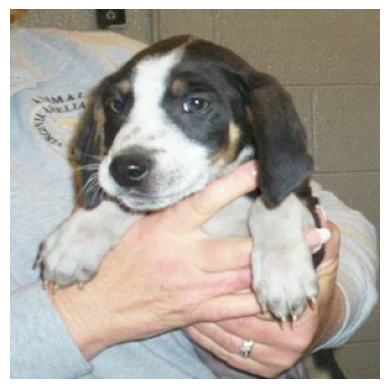

In [10]:
# Load the image
im_orig = LoadImage('./dataset/cat_dog/Dog/10.jpg')
im_tensor = PreprocessImages([im_orig])
# Show the image
ShowImage(im_orig)

predictions = model(im_tensor)
predictions = predictions.detach().numpy()
prediction_class = np.argmax(predictions[0])
call_model_args = {class_idx_str: prediction_class}

print("Prediction class: " + str(prediction_class))  # Should be a doberman, class idx = 236
im = im_orig.astype(np.float32)

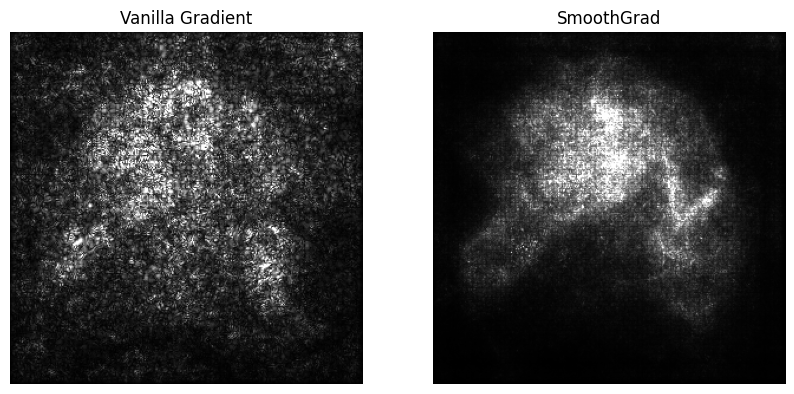

In [11]:
# Construct the saliency object. This alone doesn't do anthing.
gradient_saliency = saliency.GradientSaliency()

# Compute the vanilla mask and the smoothed mask.
vanilla_mask_3d = gradient_saliency.GetMask(im, call_model_function, call_model_args)
smoothgrad_mask_3d = gradient_saliency.GetSmoothedMask(im, call_model_function, call_model_args)

# Call the visualization methods to convert the 3D tensors to 2D grayscale.
vanilla_mask_grayscale = saliency.VisualizeImageGrayscale(vanilla_mask_3d)
smoothgrad_mask_grayscale = saliency.VisualizeImageGrayscale(smoothgrad_mask_3d)

# Set up matplot lib figures.
ROWS = 1
COLS = 2
UPSCALE_FACTOR = 10
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Render the saliency masks.
ShowGrayscaleImage(vanilla_mask_grayscale, title='Vanilla Gradient', ax=P.subplot(ROWS, COLS, 1))
ShowGrayscaleImage(smoothgrad_mask_grayscale, title='SmoothGrad', ax=P.subplot(ROWS, COLS, 2))

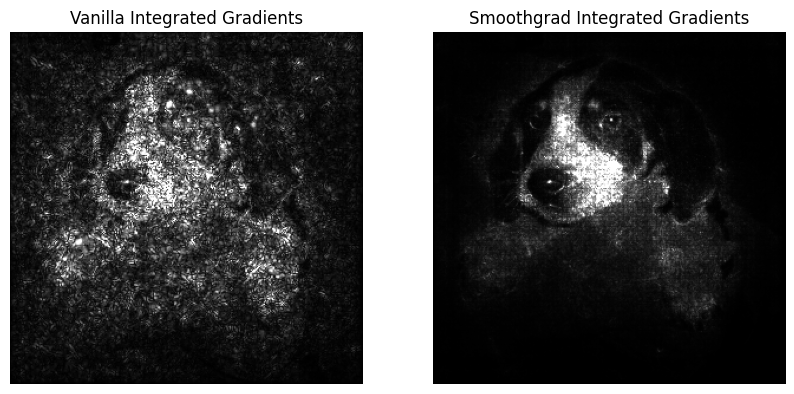

In [12]:

# Construct the saliency object. This alone doesn't do anthing.
integrated_gradients = saliency.IntegratedGradients()

# Baseline is a black image.
baseline = np.zeros(im.shape)

# Compute the vanilla mask and the smoothed mask.
vanilla_integrated_gradients_mask_3d = integrated_gradients.GetMask(
  im, call_model_function, call_model_args, x_steps=25, x_baseline=baseline, batch_size=20)
# Smoothed mask for integrated gradients will take a while since we are doing nsamples * nsamples computations.
smoothgrad_integrated_gradients_mask_3d = integrated_gradients.GetSmoothedMask(
  im, call_model_function, call_model_args, x_steps=25, x_baseline=baseline, batch_size=20)

# Call the visualization methods to convert the 3D tensors to 2D grayscale.
vanilla_mask_grayscale = saliency.VisualizeImageGrayscale(vanilla_integrated_gradients_mask_3d)
smoothgrad_mask_grayscale = saliency.VisualizeImageGrayscale(smoothgrad_integrated_gradients_mask_3d)

# Set up matplot lib figures.
ROWS = 1
COLS = 2
UPSCALE_FACTOR = 10
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Render the saliency masks.
ShowGrayscaleImage(vanilla_mask_grayscale, title='Vanilla Integrated Gradients', ax=P.subplot(ROWS, COLS, 1))
ShowGrayscaleImage(smoothgrad_mask_grayscale, title='Smoothgrad Integrated Gradients', ax=P.subplot(ROWS, COLS, 2))